In [ ]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from loader import DVCDataset, get_loader
from utils import parse_vtt
from config import *
plt.style.use('seaborn-v0_8')

# Test DVC Loader

In [5]:
train_loader = get_loader('train', batch_size=2)
for video_ids, start_frames, end_frames, poses, batch_events in train_loader:
    print('Batch poses shape: ', poses.shape)
    for video_id, start_frame, end_frame, events in zip(video_ids, start_frames, end_frames, batch_events):
        print(f'\nVideo ID: {video_id}, Start Frame: {start_frame}, End Frame: {end_frame}')
        for i, event in enumerate(events): print(f'- Event {i}: {event}')
    break

Found 2 videos in the train split.


Building video metadata for train split: 100%|██████████| 2/2 [00:00<00:00, 42.19it/s]

Dataset initialized for train: 2 videos
Window size: 18s (225 frames @ 12.5 fps)


Batch poses shape:  torch.Size([2, 225, 77, 3])

Video ID: 5224144816887051284, Start Frame: 8394, End Frame: 8619
- Event 0: {'rel_start': 0.24888888888888888, 'rel_end': 0.41333333333333333, 'text': "This is the time when they're most easily seen in the pond usually."}
- Event 1: {'rel_start': 0.41333333333333333, 'rel_end': 0.5244444444444445, 'text': 'We have seen 18 in this pond.'}
- Event 2: {'rel_start': 0.7466666666666667, 'rel_end': 0.8577777777777778, 'text': "There's something."}
- Event 3: {'rel_start': 0.8577777777777778, 'rel_end': 0.9155555555555556, 'text': 'Is there?'}

Video ID: 5085344787448740525, Start Frame: 5885, End Frame: 6110
- Event 0: {'rel_start': 0.06666666666666667, 'rel_end': 0.28888888888888886, 'text': "Get moving, they're on their way round to nick you, now fuck off."}
- Event 1: {'rel_start': 0.28888888888888886, 'rel_end': 0.3422222222222222, 'text': "There's one there now."}
- Event 2: {'rel_start': 0.3422222222222222, 'rel_end': 0.5111111111111111

In [ ]:
train_video_ids = DVCDataset.load_subset('train')
subtitles = parse_vtt(VTT_DIR / f'{train_video_ids[0]}.vtt')
poses = train_loader.dataset.load_poses_for_video(train_video_ids[0])
print(f'Sample data: {len(subtitles)} subtitles, poses shape {poses.shape}')

Found 2 videos in the train split.
Loaded poses for 5085344787448740525: (36792, 133, 3) from 10 segments
Sample data: 675 subtitles, poses shape (36792, 133, 3)


# Training Statistics

In [2]:
train_video_ids = DVCDataset.load_subset('train')
durations = []

for video_id in tqdm(train_video_ids, desc='Processing VTT files'):
    vtt_path = VTT_DIR / f'{video_id}.vtt'
    if vtt_path.exists():
        subtitles = parse_vtt(vtt_path)
        durations.extend([s['duration'] for s in subtitles])
    else: print(f'Warning: VTT not found for {video_id}')
if not durations: print('No sentence durations could be extracted. Please check VTT files.')

Found 1658 videos in the train split.


Processing VTT files:   0%|          | 0/1658 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame(durations, columns=['duration_seconds'])
print('Subtitle Duration Statistics (in seconds)')
stats = df['duration_seconds'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
stats

Subtitle Duration Statistics (in seconds)


count    935505.000000
mean          3.616974
std           2.906213
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
90%           7.000000
95%           9.000000
99%          14.000000
max         199.000000
Name: duration_seconds, dtype: float64

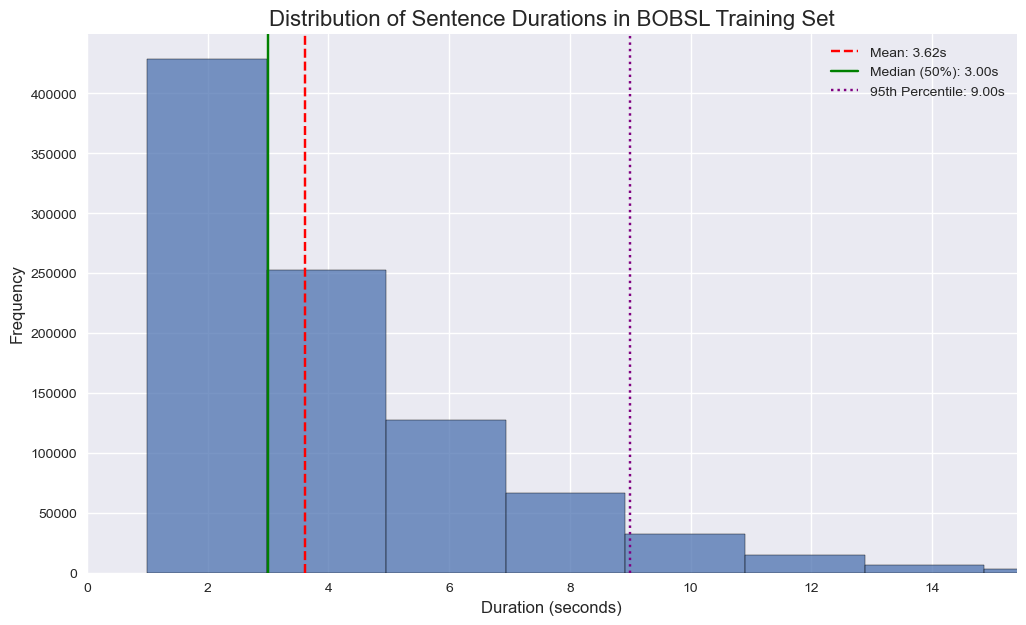

In [4]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.histplot(data=df, x='duration_seconds', bins=100, ax=ax)

# Add vertical lines for key statistics
plt.axvline(stats['mean'], color='r', linestyle='--', label=f"Mean: {stats['mean']:.2f}s")
plt.axvline(stats['50%'], color='g', linestyle='-', label=f"Median (50%): {stats['50%']:.2f}s")
plt.axvline(stats['95%'], color='purple', linestyle=':', label=f"95th Percentile: {stats['95%']:.2f}s")

ax.set_title('Distribution of Sentence Durations in BOBSL Training Set', fontsize=16)
ax.set_xlabel('Duration (seconds)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend()
ax.set_xlim(0, stats['99%'] * 1.1) # Limit x-axis for better readability, as there might be extreme outliers
plt.show()

In [5]:
recommendation_duration = (stats['95%'] * 2) # A window that can comfortably fit two long sentences
print(f"A good starting point for `WINDOW_DURATION_SECONDS` in config.py would be a value that can capture multiple sentences.")
print(f"The 95th percentile is {stats['95%']:.2f}s. A window of {recommendation_duration:.2f}s could potentially hold 2 of these longer sentences.")

A good starting point for `WINDOW_DURATION_SECONDS` in config.py would be a value that can capture multiple sentences.
The 95th percentile is 9.00s. A window of 18.00s could potentially hold 2 of these longer sentences.
